In [26]:
%load_ext autoreload

import re, time, os, shutil, json
import numpy as np
import configdot
from tqdm import tqdm

from collections import defaultdict
from IPython.core.debugger import set_trace

import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast
import torch.optim as optim
from models.v2v import V2VModel

from losses import *
from dataset import setup_dataloaders
from utils import save, get_capacity, calc_gradient_norm, get_label
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
LOGDIR = '/workspace/RawData/FCDNet/logs/'
logname = 'features_comparison/v2v-IN_autocast_DICE_lr-1e-3_nG-bs2-AUG-ALL@28.06.2022-10'

logdir = os.path.join(LOGDIR, logname)

In [5]:
val_preds_path = os.path.join(logdir, 'best_val_preds')

In [6]:
def get_latest_weights(logdir, number=None):
    
    checkpoints_path = os.path.join(logdir, 'checkpoints')
    
    if number is None:
        checkpoints_names = os.listdir(checkpoints_path)
        checkpoints_names = sorted(checkpoints_names, key=lambda x: int(re.findall('\d+', x)[0]))
        checkpoint = checkpoints_names[-1]
    else:
        checkpoint = f'weights_{number}.pth'
    
    return os.path.join(checkpoints_path, checkpoint)

In [7]:
best_val_preds = {}
for label in os.listdir(val_preds_path):
    val_preds_label_path = os.path.join(val_preds_path, label)
    best_val_preds[label] = torch.load(val_preds_label_path)[0,0]

### Load model, setup dataloaders

In [8]:
config = configdot.parse_config('configs/config.ini')

In [11]:
# essential for the proper samplers functioning
assert config.opt.val_batch_size == 1
DEVICE = 'cpu' # 'cuda:1' #'' # 'cpu'
device = torch.device(DEVICE)


#########
# MODEL #
#########
# assert config.model.name == "v2v"
# model = V2VModel(config).to(device)

###################
# CREATE DATASETS #
###################
train_loader, val_loader = setup_dataloaders(config)

print('val dataloder len: ', len(val_loader), 'train dataloder len: ', len(train_loader))

Train set length: 87
Test set length: 10
val dataloder len:  10 train dataloder len:  44


# Forward pass

In [12]:
SAVE_PREDS = False

if SAVE_PREDS:
    predictions_path = os.path.join(logdir, 'predictions')
    if not os.path.exists(predictions_path):
        os.makedirs(predictions_path)

In [21]:
best_val_preds['n43'].shape

(128, 128, 128)

In [58]:
dataloader = val_loader

brains = {}
labels_gt = {}
metric_dict = defaultdict(list)
labels_pred = {}
labels_ref = {}

with torch.no_grad():

    # bs = 1
    # brain_tensor - [1,C,H,W,D]
    # mask_tensor - [1,1,H,W,D]
    # label_tensor - [1,1,H,W,D]
    
    #######################
    # ITERATE OVER BRAINS #
    #######################
    iterator = enumerate(dataloader)
    for iter_i, data_tensors in tqdm(iterator):

        brain_tensor, label_tensor = data_tensors['image'], data_tensors['seg']

        brain_tensor = brain_tensor.to(device)
        label_tensor = label_tensor.to(device)

        label = get_label(dataloader.dataset.data[iter_i]['seg'])
        print(f'Label: {label}')

         # forward pass
#         label_tensor_predicted = model(brain_tensor) # -> [1,1,ps,ps,ps]

        label_tensor_predicted = torch.tensor(best_val_preds[label][None,None,...]).to(device)

        cov = coverage(label_tensor_predicted, label_tensor).item()
        fp = false_positive(label_tensor_predicted, label_tensor).item()
        fn = false_negative(label_tensor_predicted, label_tensor).item()
        dice = dice_score(label_tensor_predicted > 0, label_tensor).item()

        metric_dict['coverage'].append(cov) # a.k.a recall
        metric_dict['false_positive'].append(fp)
        metric_dict['false_negative'].append(fn)
        metric_dict['dice_score'].append(dice)
        
        print(label, dice)

        brains[label] = brain_tensor[0].detach().cpu().numpy()
        labels_gt[label] = label_tensor[0,0].detach().cpu().numpy()
        label_tensor_predicted = label_tensor_predicted[0,0].detach().cpu()
        labels_pred[label] = label_tensor_predicted.numpy()

        if SAVE_PREDS:
            torch.save(label_tensor_predicted, os.path.join(predictions_path, f'{label}'))

0it [00:00, ?it/s]

Label: n43


1it [00:03,  3.72s/it]

n43 0.0005204249755479395


2it [00:07,  3.75s/it]

Label: n72
n72 0.00037299099494703114


3it [00:11,  3.70s/it]

Label: n46
n46 0.0002135084941983223


4it [00:14,  3.67s/it]

Label: n32
n32 0.0019167694263160229


5it [00:18,  3.71s/it]

Label: G061
G061 0.00018660540808923542


6it [00:22,  3.75s/it]

Label: n37
n37 0.000301365798804909


7it [00:26,  3.78s/it]

Label: n88
n88 0.0004868719552177936


8it [00:29,  3.77s/it]

Label: G150
G150 0.00044230479397810996


9it [00:33,  3.78s/it]

Label: n76
n76 0.00020193445379845798


10it [00:37,  3.76s/it]

Label: n77
n77 0.0003520205500535667


In [29]:
# plt.ion()
# plt.figure(figsize=(10,5),dpi=200)
# plt.bar(metric_dict['dice_score'].keys(), metric_dict['dice_score'].values(), alpha=0.5, label='V2V')
# exp_name = logdir.split('/')[1]
# plt.title(f'Val')
# plt.ylabel('Dice score')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

In [30]:
# plt.ion()
# plt.figure(figsize=(10,5),dpi=200)
# plt.bar(metric_dict['coverage'].keys(), metric_dict['coverage'].values(), alpha=0.5, label='V2V')
# exp_name = logdir.split('/')[1]
# plt.title(f'Val')
# plt.ylabel('Recall')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

In [38]:
# dices = np.array(list(metric_dict['dice_score'].values()))
# labels = np.array(list(metric_dict['dice_score'].keys()))

In [43]:
image_path = os.path.join(logdir, 'images_val')
if not os.path.exists(image_path):
    os.makedirs(image_path)

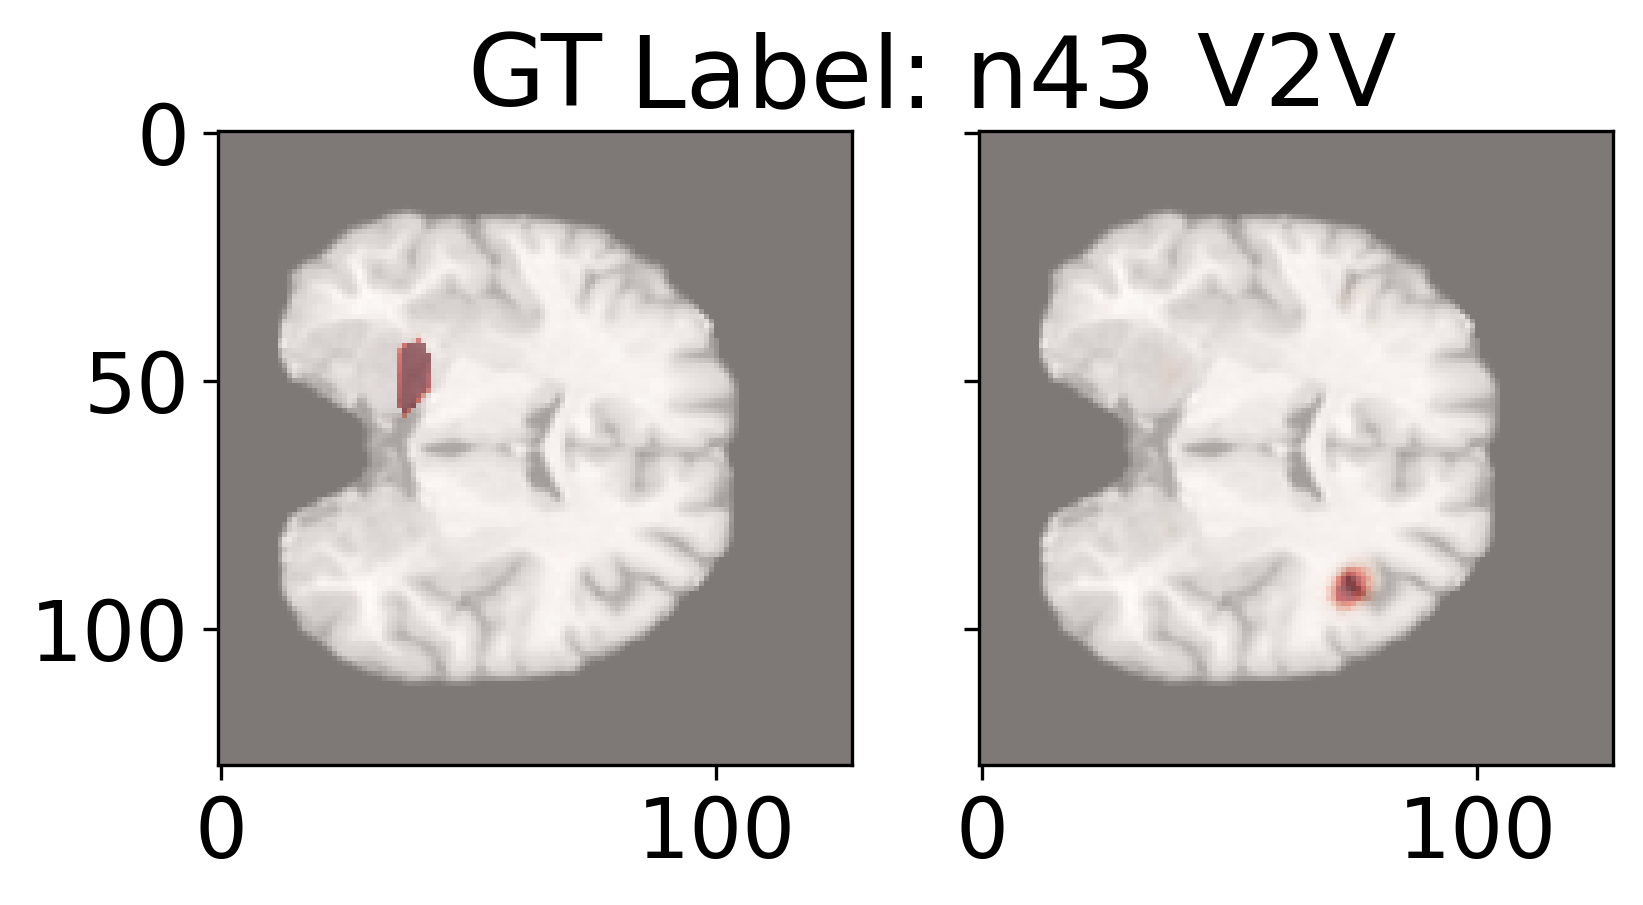

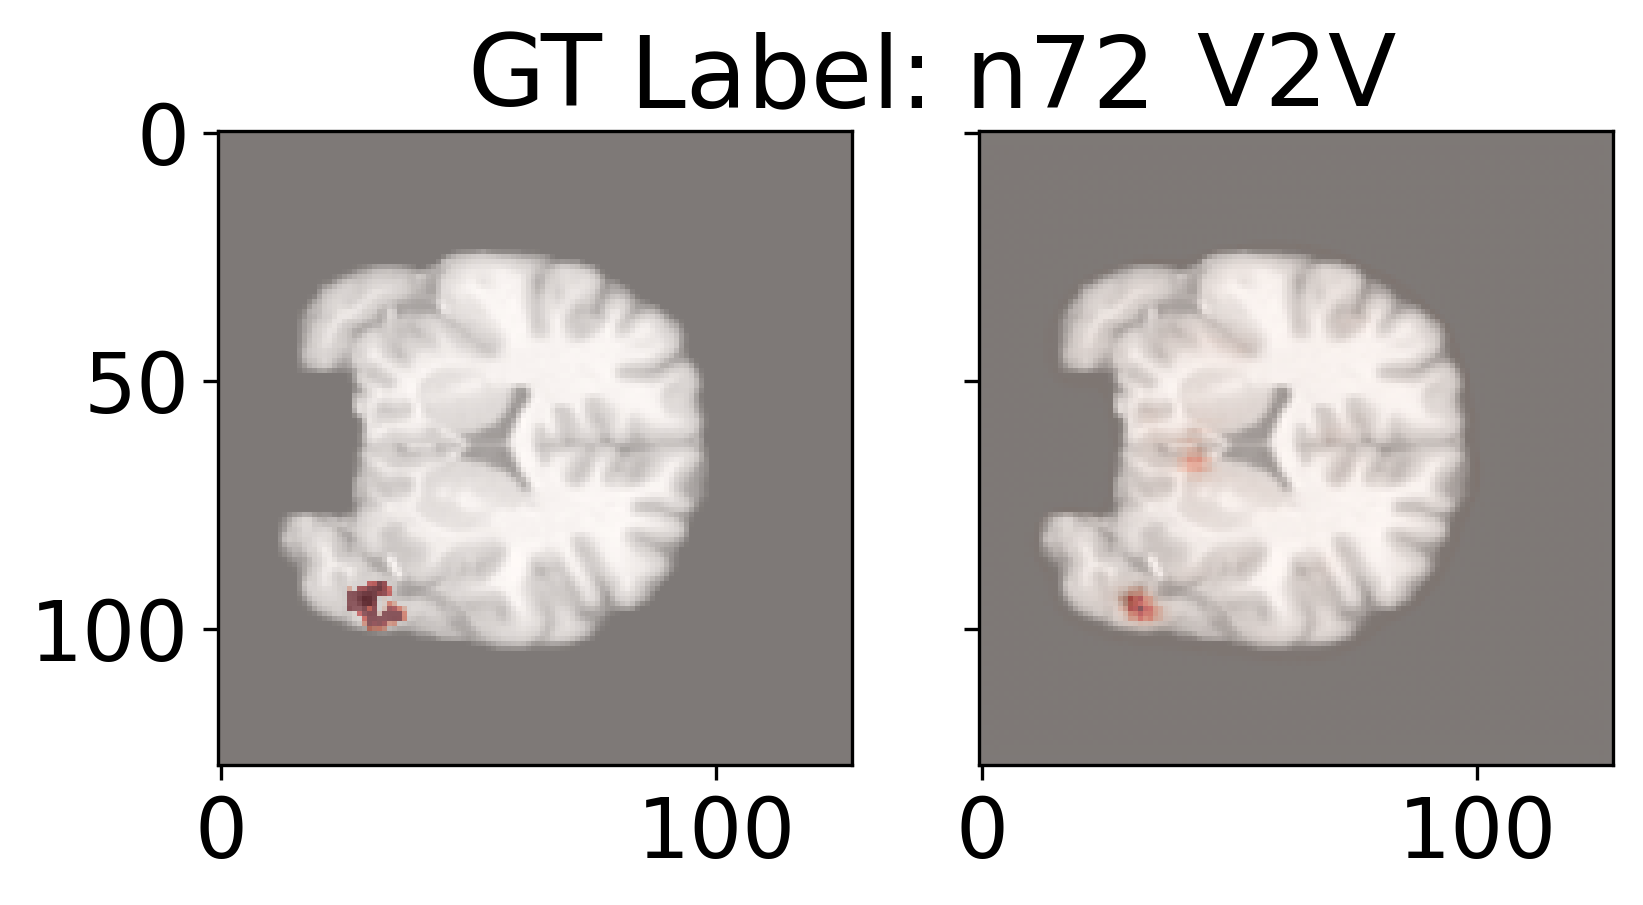

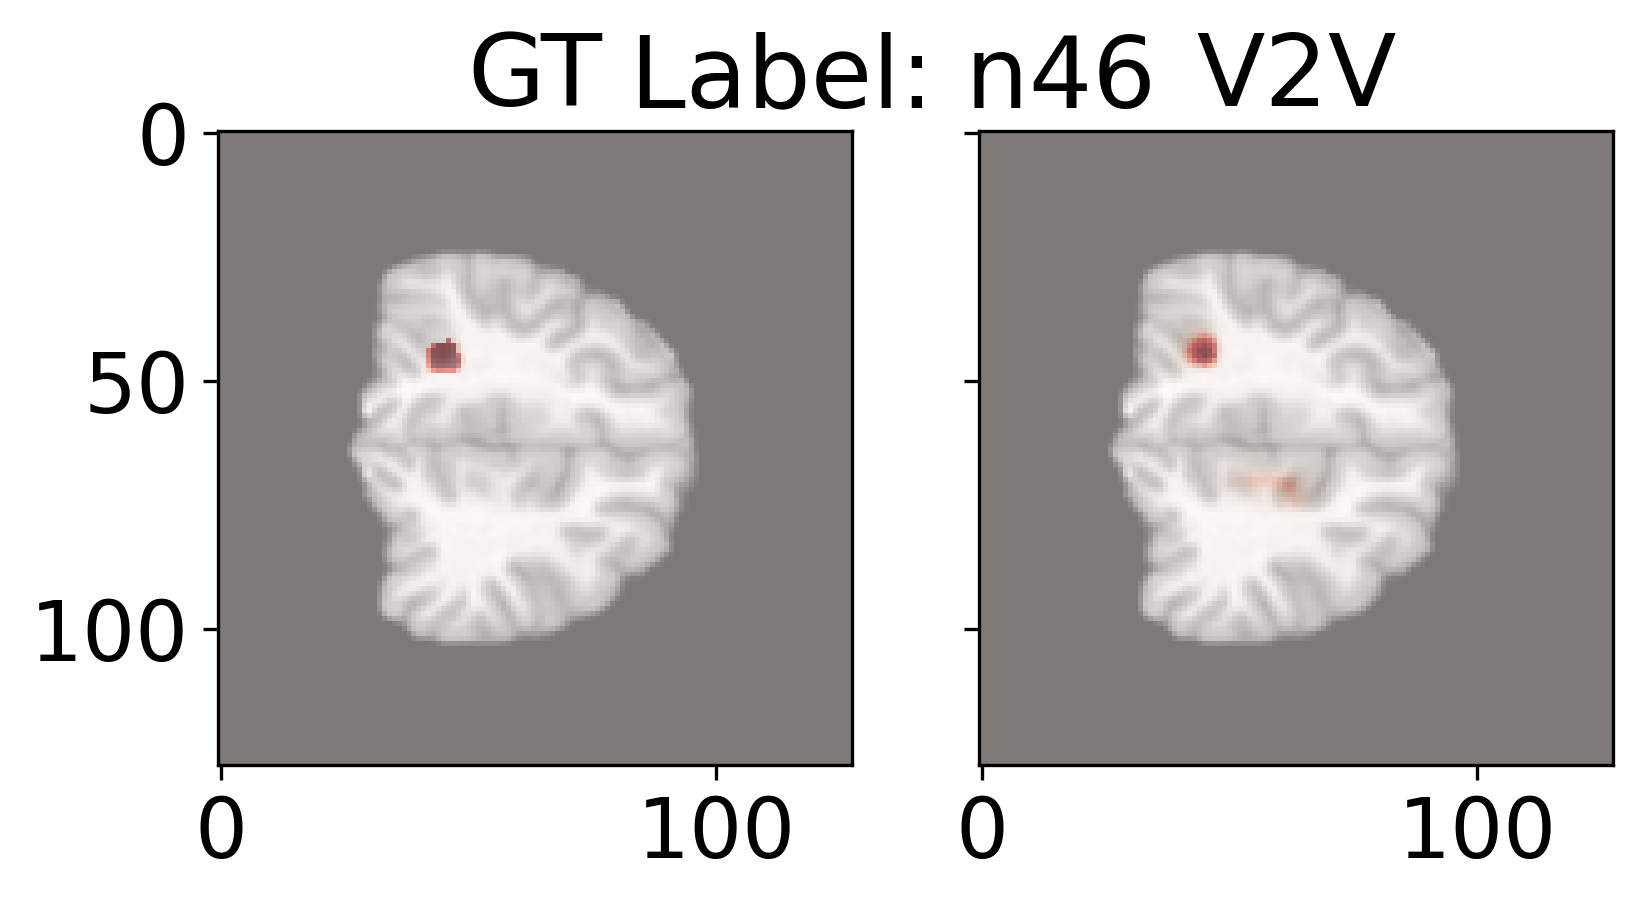

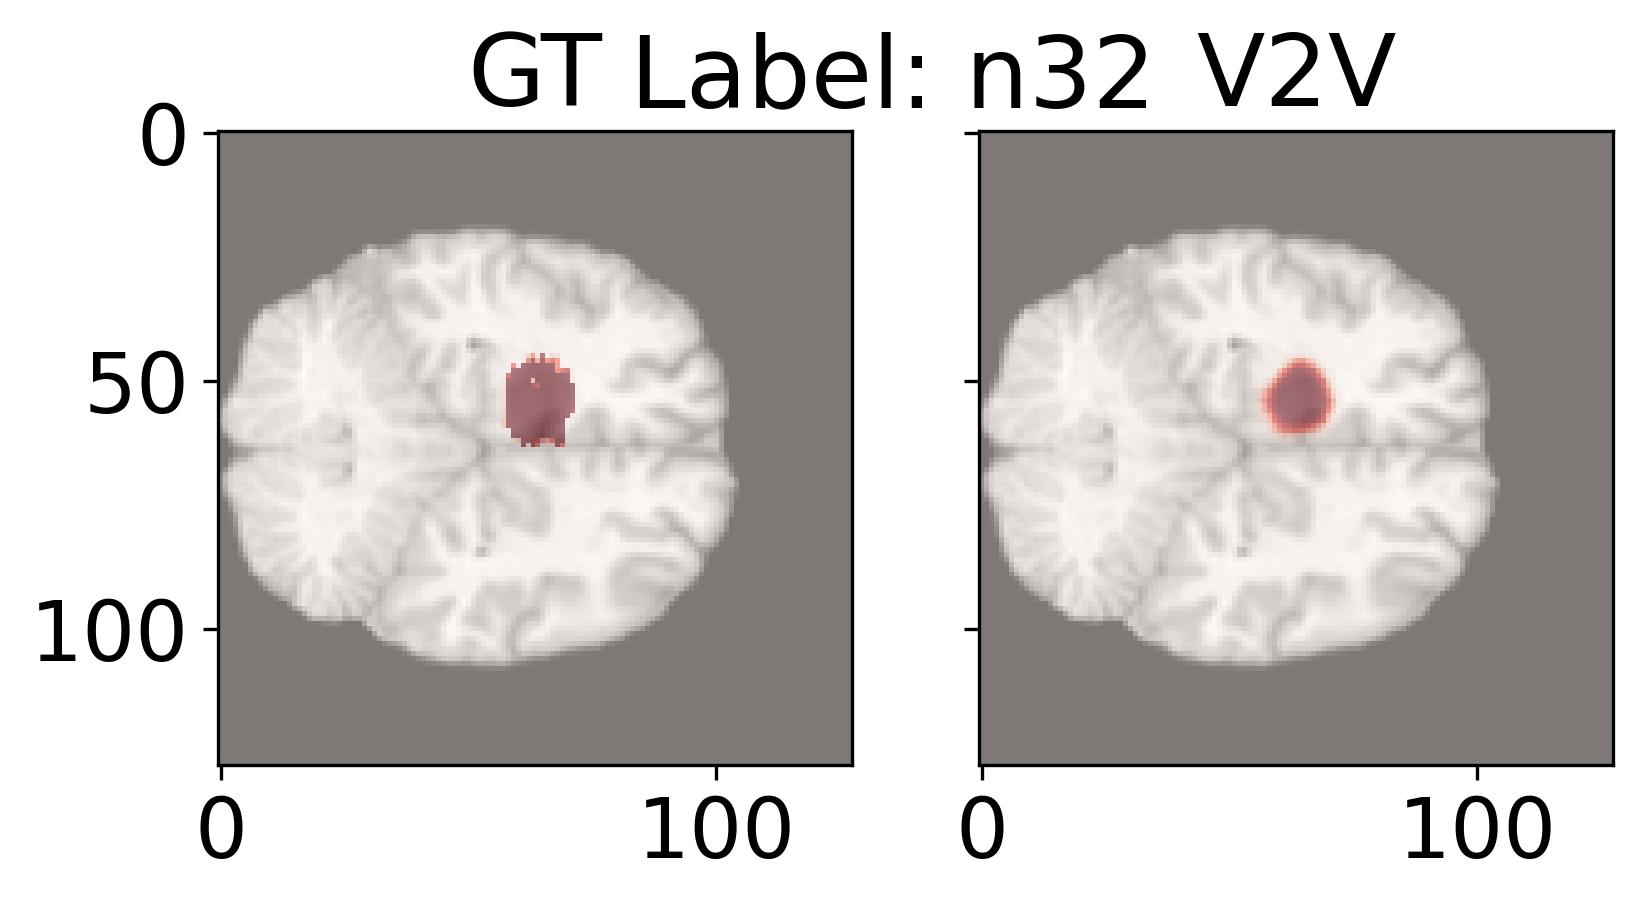

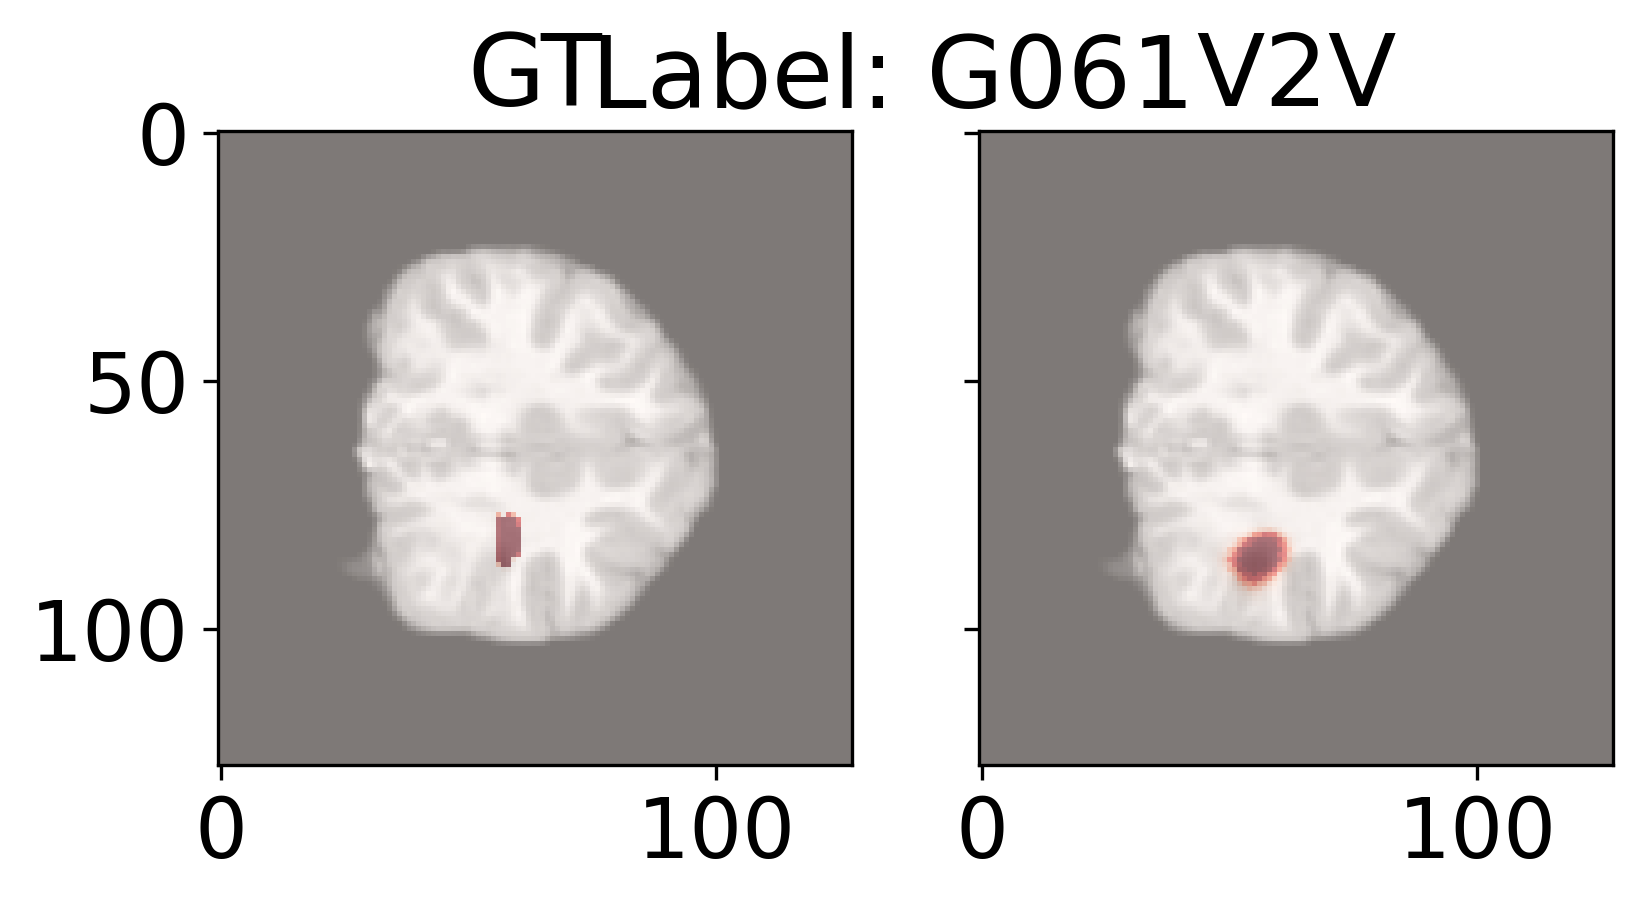

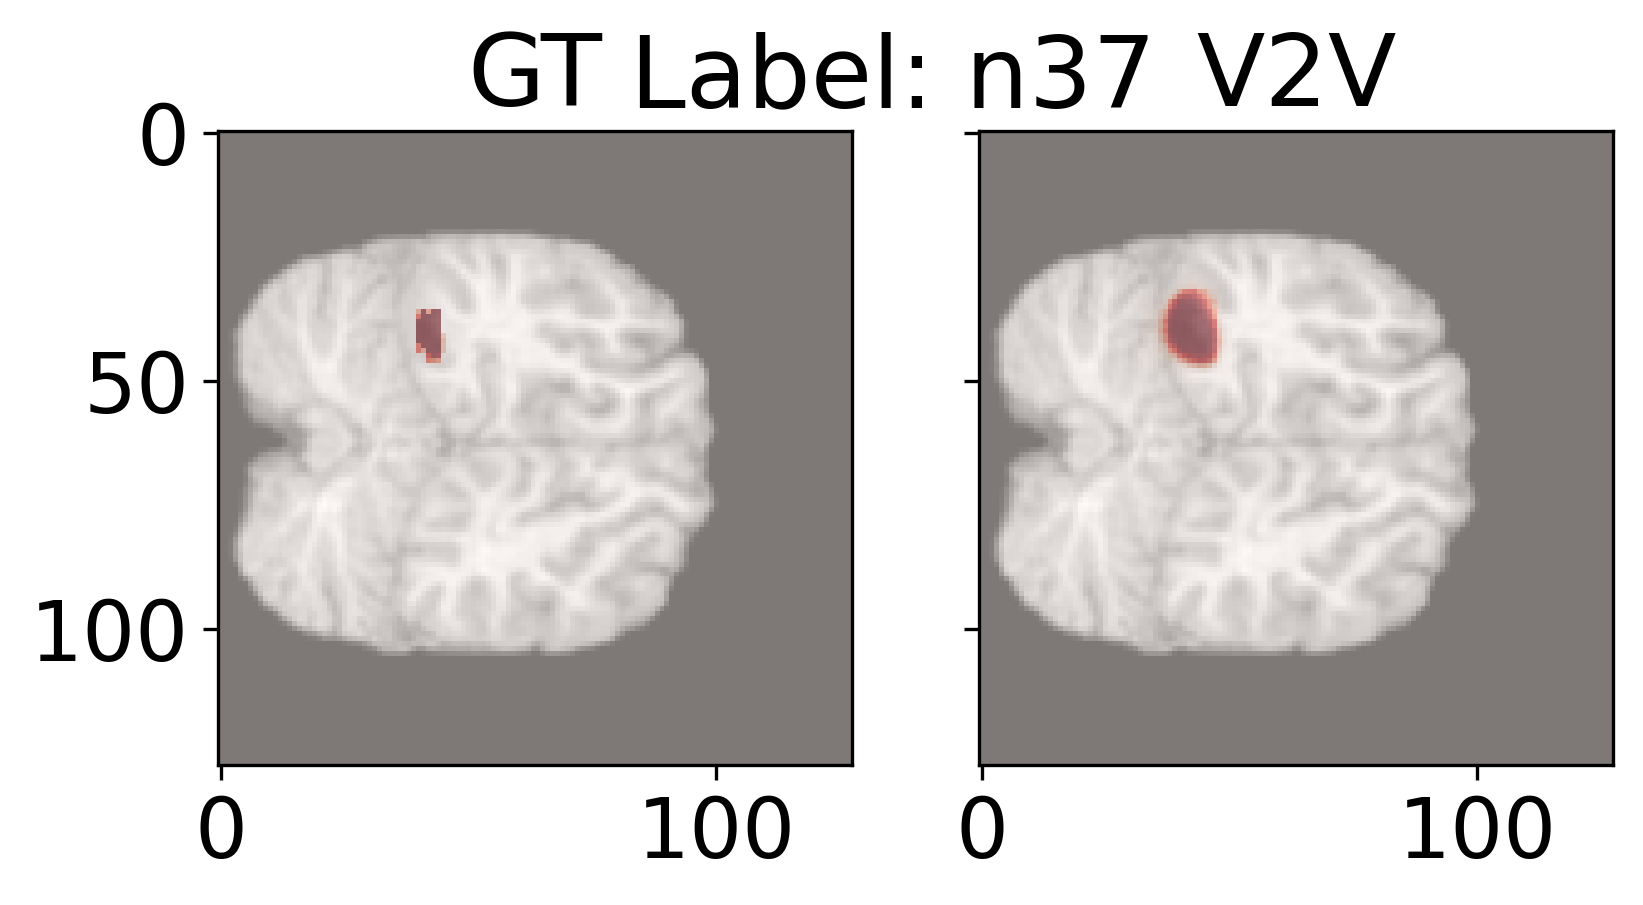

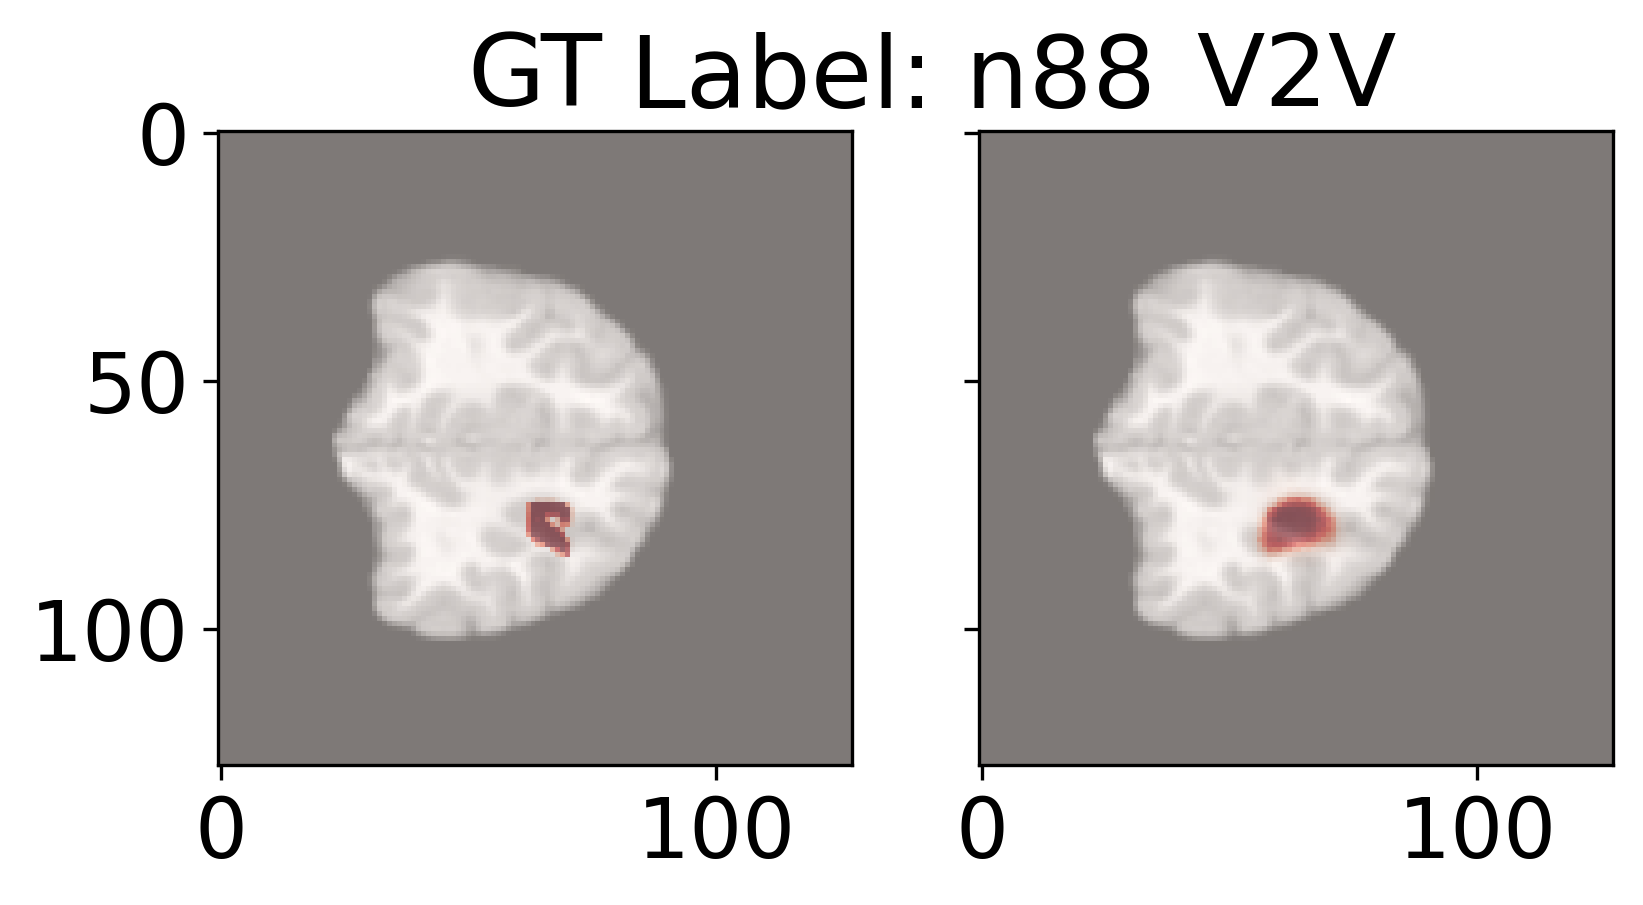

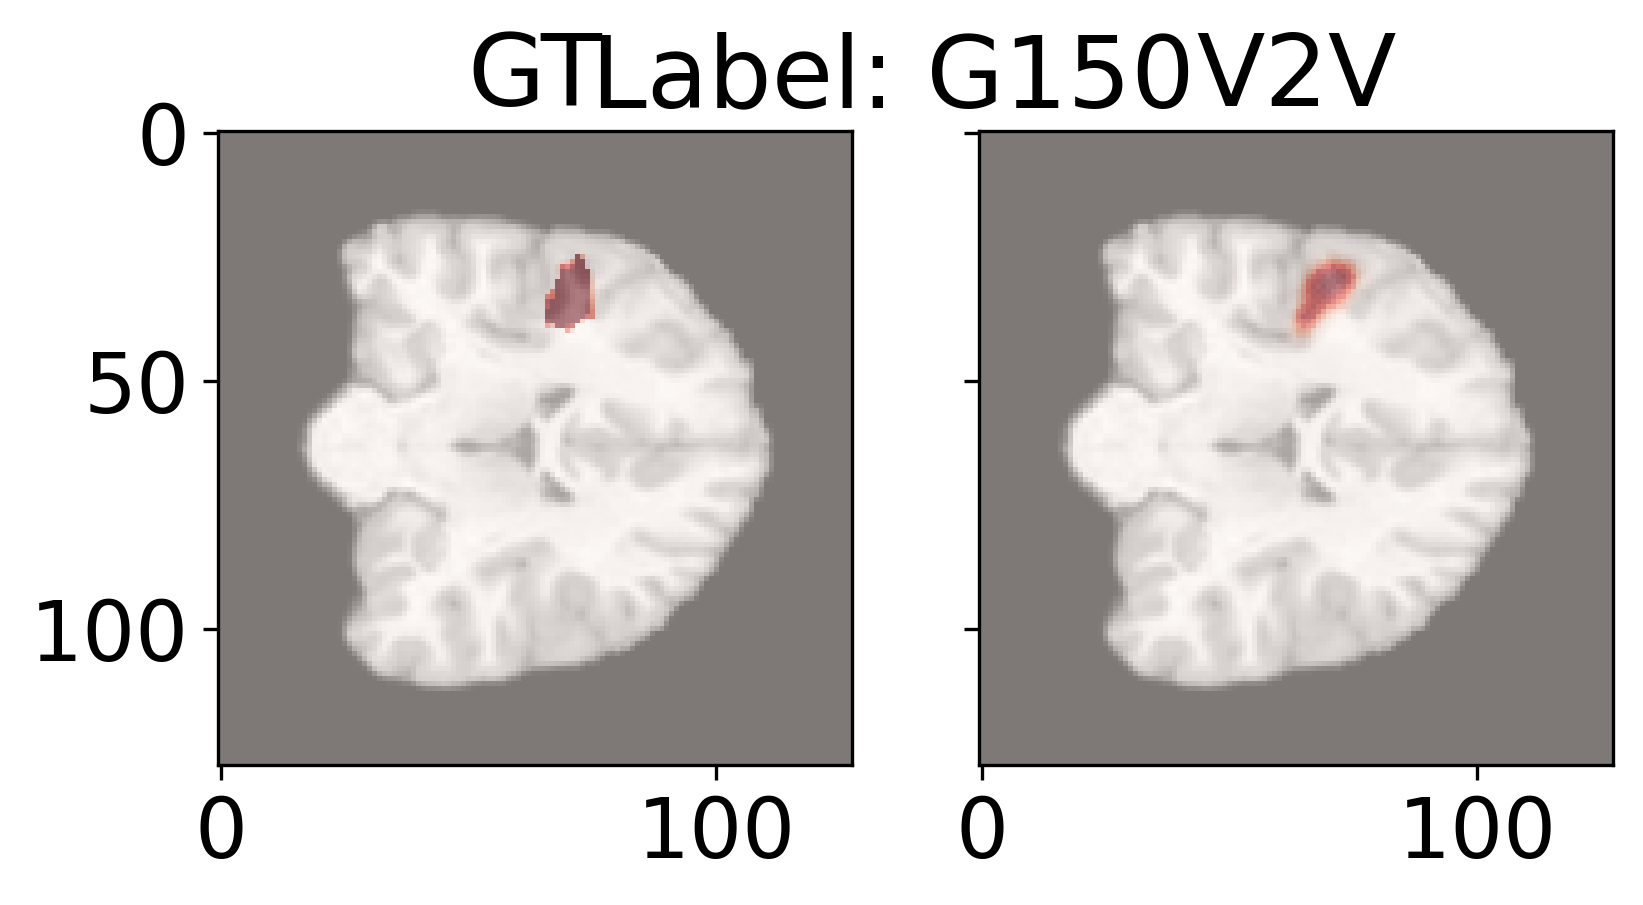

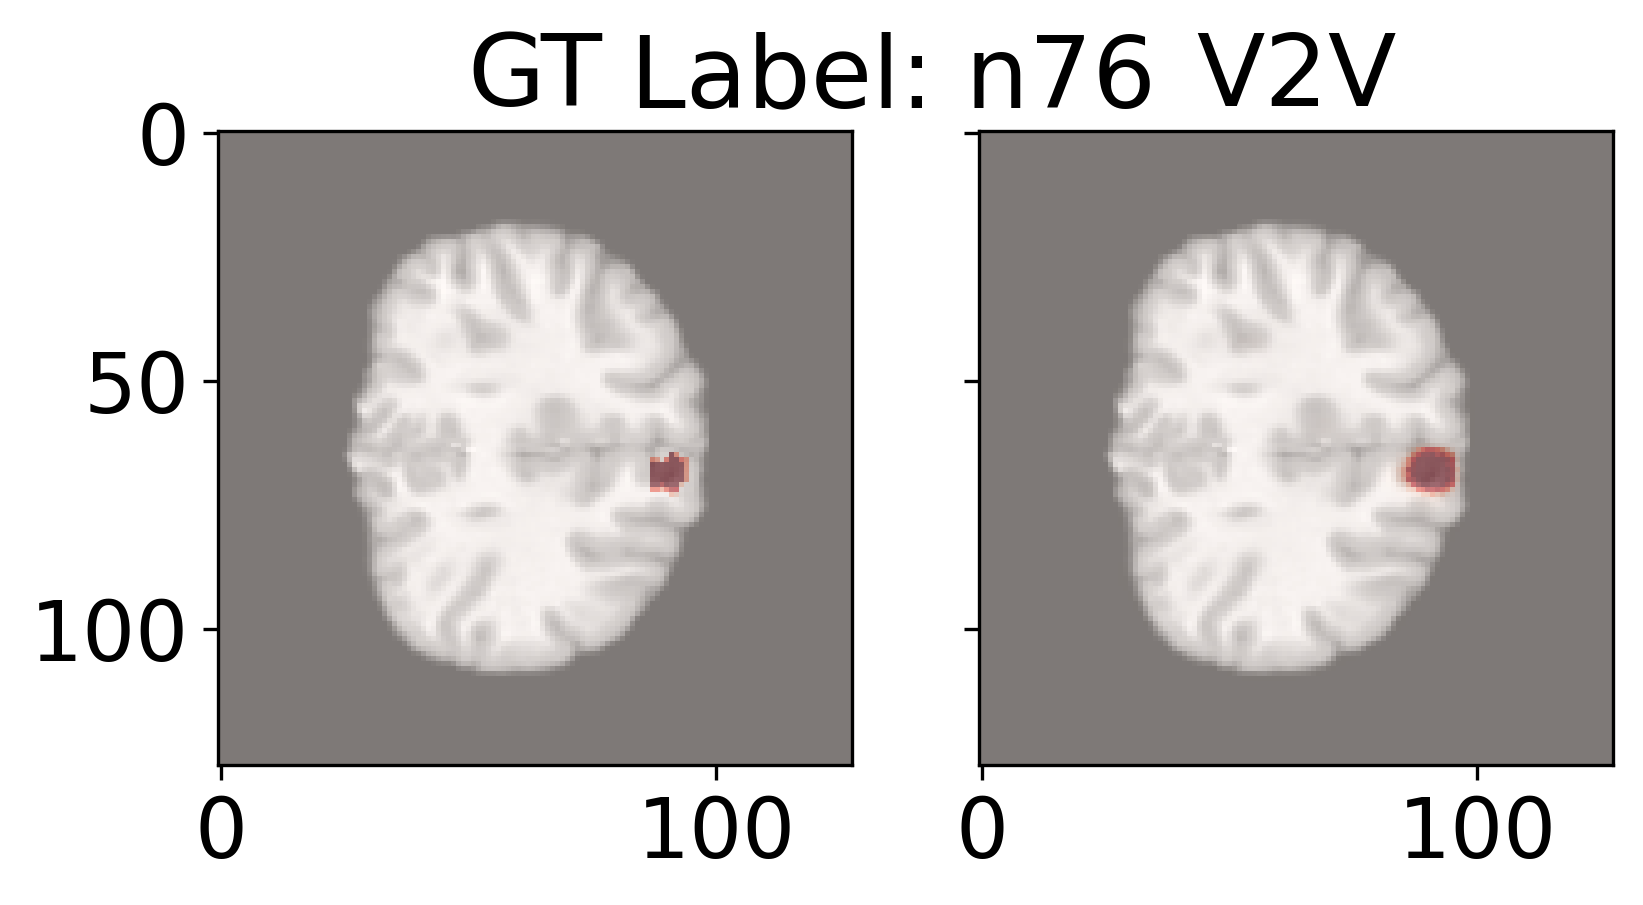

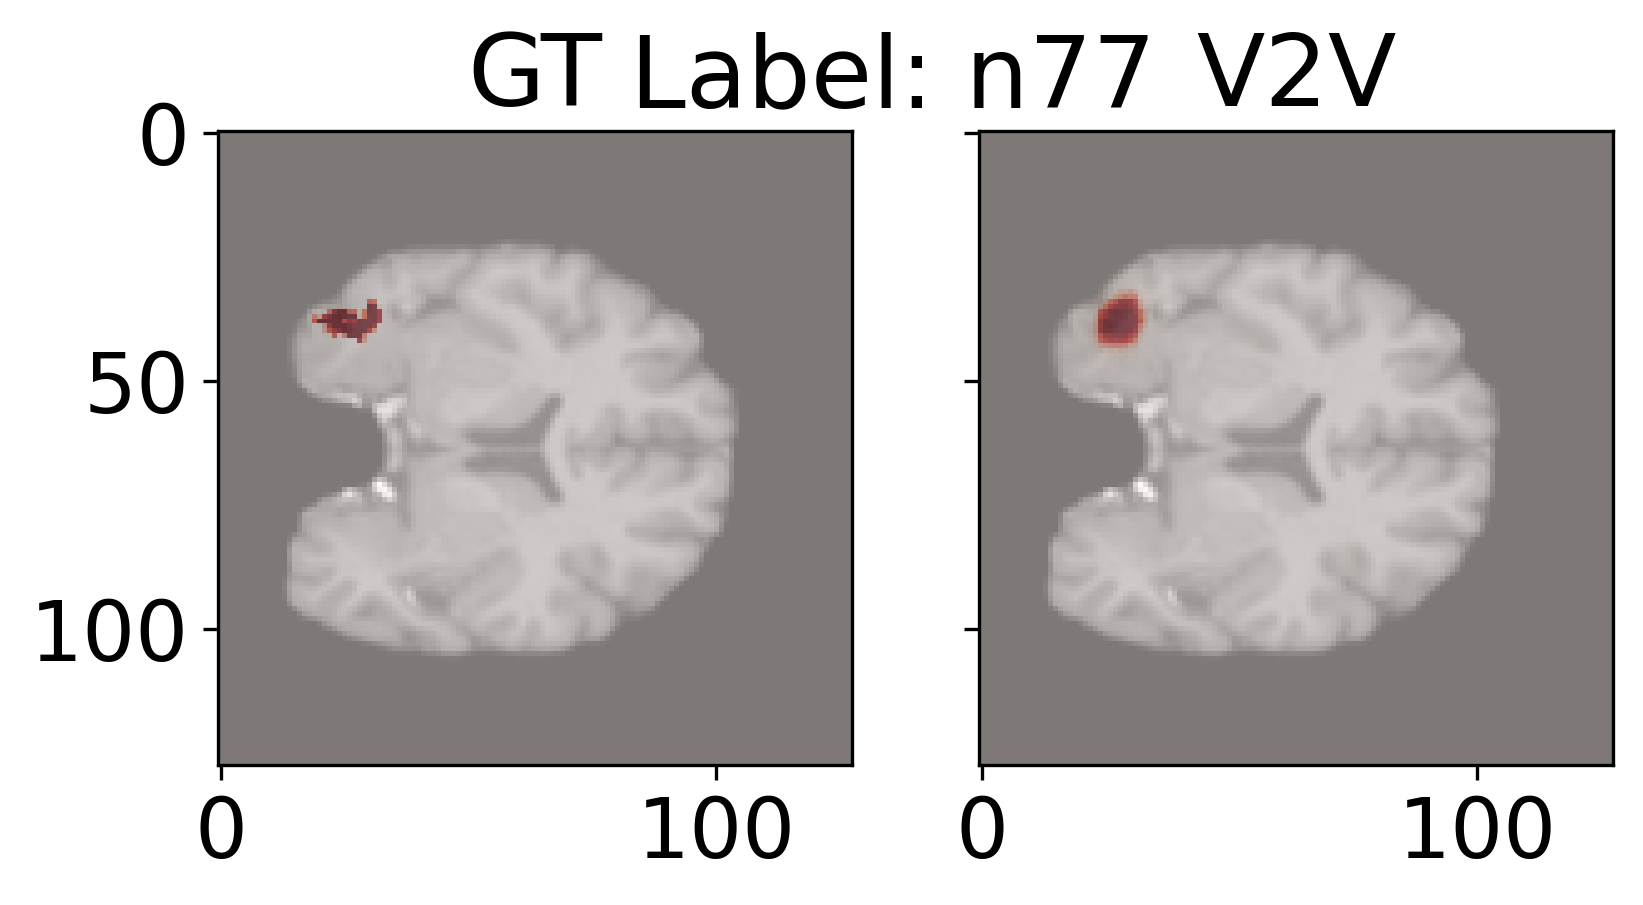

In [55]:
for label in brains.keys():

    brain = brains[label][0]
    label_gt = labels_gt[label]
    label_pred = labels_pred[label]

    fig, ax = plt.subplots(1,2, sharex=True, sharey=True, dpi=300)
    X_max, Y_max, Z_max = brain.shape

    y_slice_pos = label_gt.sum(axis=(0,-1)).argmax()

    brain_slice = brain[:,y_slice_pos,:]
    label_gt_slice = label_gt[:,y_slice_pos,:]
    ax[0].imshow(brain_slice, cmap='gray')
    ax[0].imshow(label_gt_slice, cmap='Reds', alpha=0.5)
    ax[0].set_title('GT')

    label_pred_slice = label_pred[:,y_slice_pos,:].astype(float)
    ax[1].imshow(brain_slice, cmap='gray')
    ax[1].imshow(label_pred_slice, cmap='Reds', alpha=0.5)
    ax[1].set_title('V2V')
    
    fig.suptitle(f'Label: {label}', y=.85)

    plt.show()
    